In [1]:
!pip install -q kaggle

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pickle as pkl

In [3]:
!kaggle datasets download -d varsharam/walmart-sales-dataset-of-45stores

Dataset URL: https://www.kaggle.com/datasets/varsharam/walmart-sales-dataset-of-45stores
License(s): unknown
  0% 0.00/122k [00:00<?, ?B/s]
100% 122k/122k [00:00<00:00, 55.1MB/s]


In [4]:
from zipfile import ZipFile
# Specify the path to the zip file
zip_file_path = '/content/walmart-sales-dataset-of-45stores.zip'

# Specify the directory where the files will be extracted
extract_to = '/content'

# Unzipping the file
with ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("Unzipping complete!")


Unzipping complete!


In [5]:
df = pd.read_csv('/content/walmart-sales-dataset-of-45stores.csv')
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [7]:
df.columns

Index(['Store', 'Date', 'Weekly_Sales', 'Holiday_Flag', 'Temperature',
       'Fuel_Price', 'CPI', 'Unemployment'],
      dtype='object')

In [8]:
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

In [9]:
df['Store'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45])

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         6435 non-null   int64         
 1   Date          6435 non-null   datetime64[ns]
 2   Weekly_Sales  6435 non-null   float64       
 3   Holiday_Flag  6435 non-null   int64         
 4   Temperature   6435 non-null   float64       
 5   Fuel_Price    6435 non-null   float64       
 6   CPI           6435 non-null   float64       
 7   Unemployment  6435 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 402.3 KB


In [11]:
df.set_index('Date', inplace=True)
df.head(2)

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
Date,,,,,,,
2010-02-05,1,1643690.90,0,42.31,2.572,211.096358,8.106
2010-02-12,1,1641957.44,1,38.51,2.548,211.242170,8.106


In [12]:
df_list = [0]

# taking all the dataframes with their stores number into list to make model for each one seperately
for i in range(1,46):
  temp_df = df[df['Store']==i]
  df_list.append(temp_df)

In [13]:
# length of store list first element is not relevant
len(df_list)

46

In [14]:
# time series data for 3rd store
df_list[3]

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
Date,,,,,,,
2010-02-05,3,461622.22,0,45.71,2.572,214.424881,7.368
2010-02-12,3,420728.96,1,47.93,2.548,214.574792,7.368
2010-02-19,3,421642.19,0,47.07,2.514,214.619887,7.368
2010-02-26,3,407204.86,0,52.05,2.561,214.647513,7.368
2010-03-05,3,415202.04,0,53.04,2.625,214.675139,7.368
...,...,...,...,...,...,...,...
2012-09-28,3,389813.02,0,77.46,3.666,226.518093,6.334
2012-10-05,3,443557.65,0,72.74,3.617,226.721036,6.034
2012-10-12,3,410804.39,0,70.31,3.601,226.923979,6.034


In [15]:
# trial to access data for any store just write like this
df[df['Store']==45]

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
Date,,,,,,,
2010-02-05,45,890689.51,0,27.31,2.784,181.871190,8.992
2010-02-12,45,656988.64,1,27.73,2.773,181.982317,8.992
2010-02-19,45,841264.04,0,31.27,2.745,182.034782,8.992
2010-02-26,45,741891.65,0,34.89,2.754,182.077469,8.992
2010-03-05,45,777951.22,0,37.13,2.777,182.120157,8.992
...,...,...,...,...,...,...,...
2012-09-28,45,713173.95,0,64.88,3.997,192.013558,8.684
2012-10-05,45,733455.07,0,64.89,3.985,192.170412,8.667
2012-10-12,45,734464.36,0,54.47,4.000,192.327265,8.667


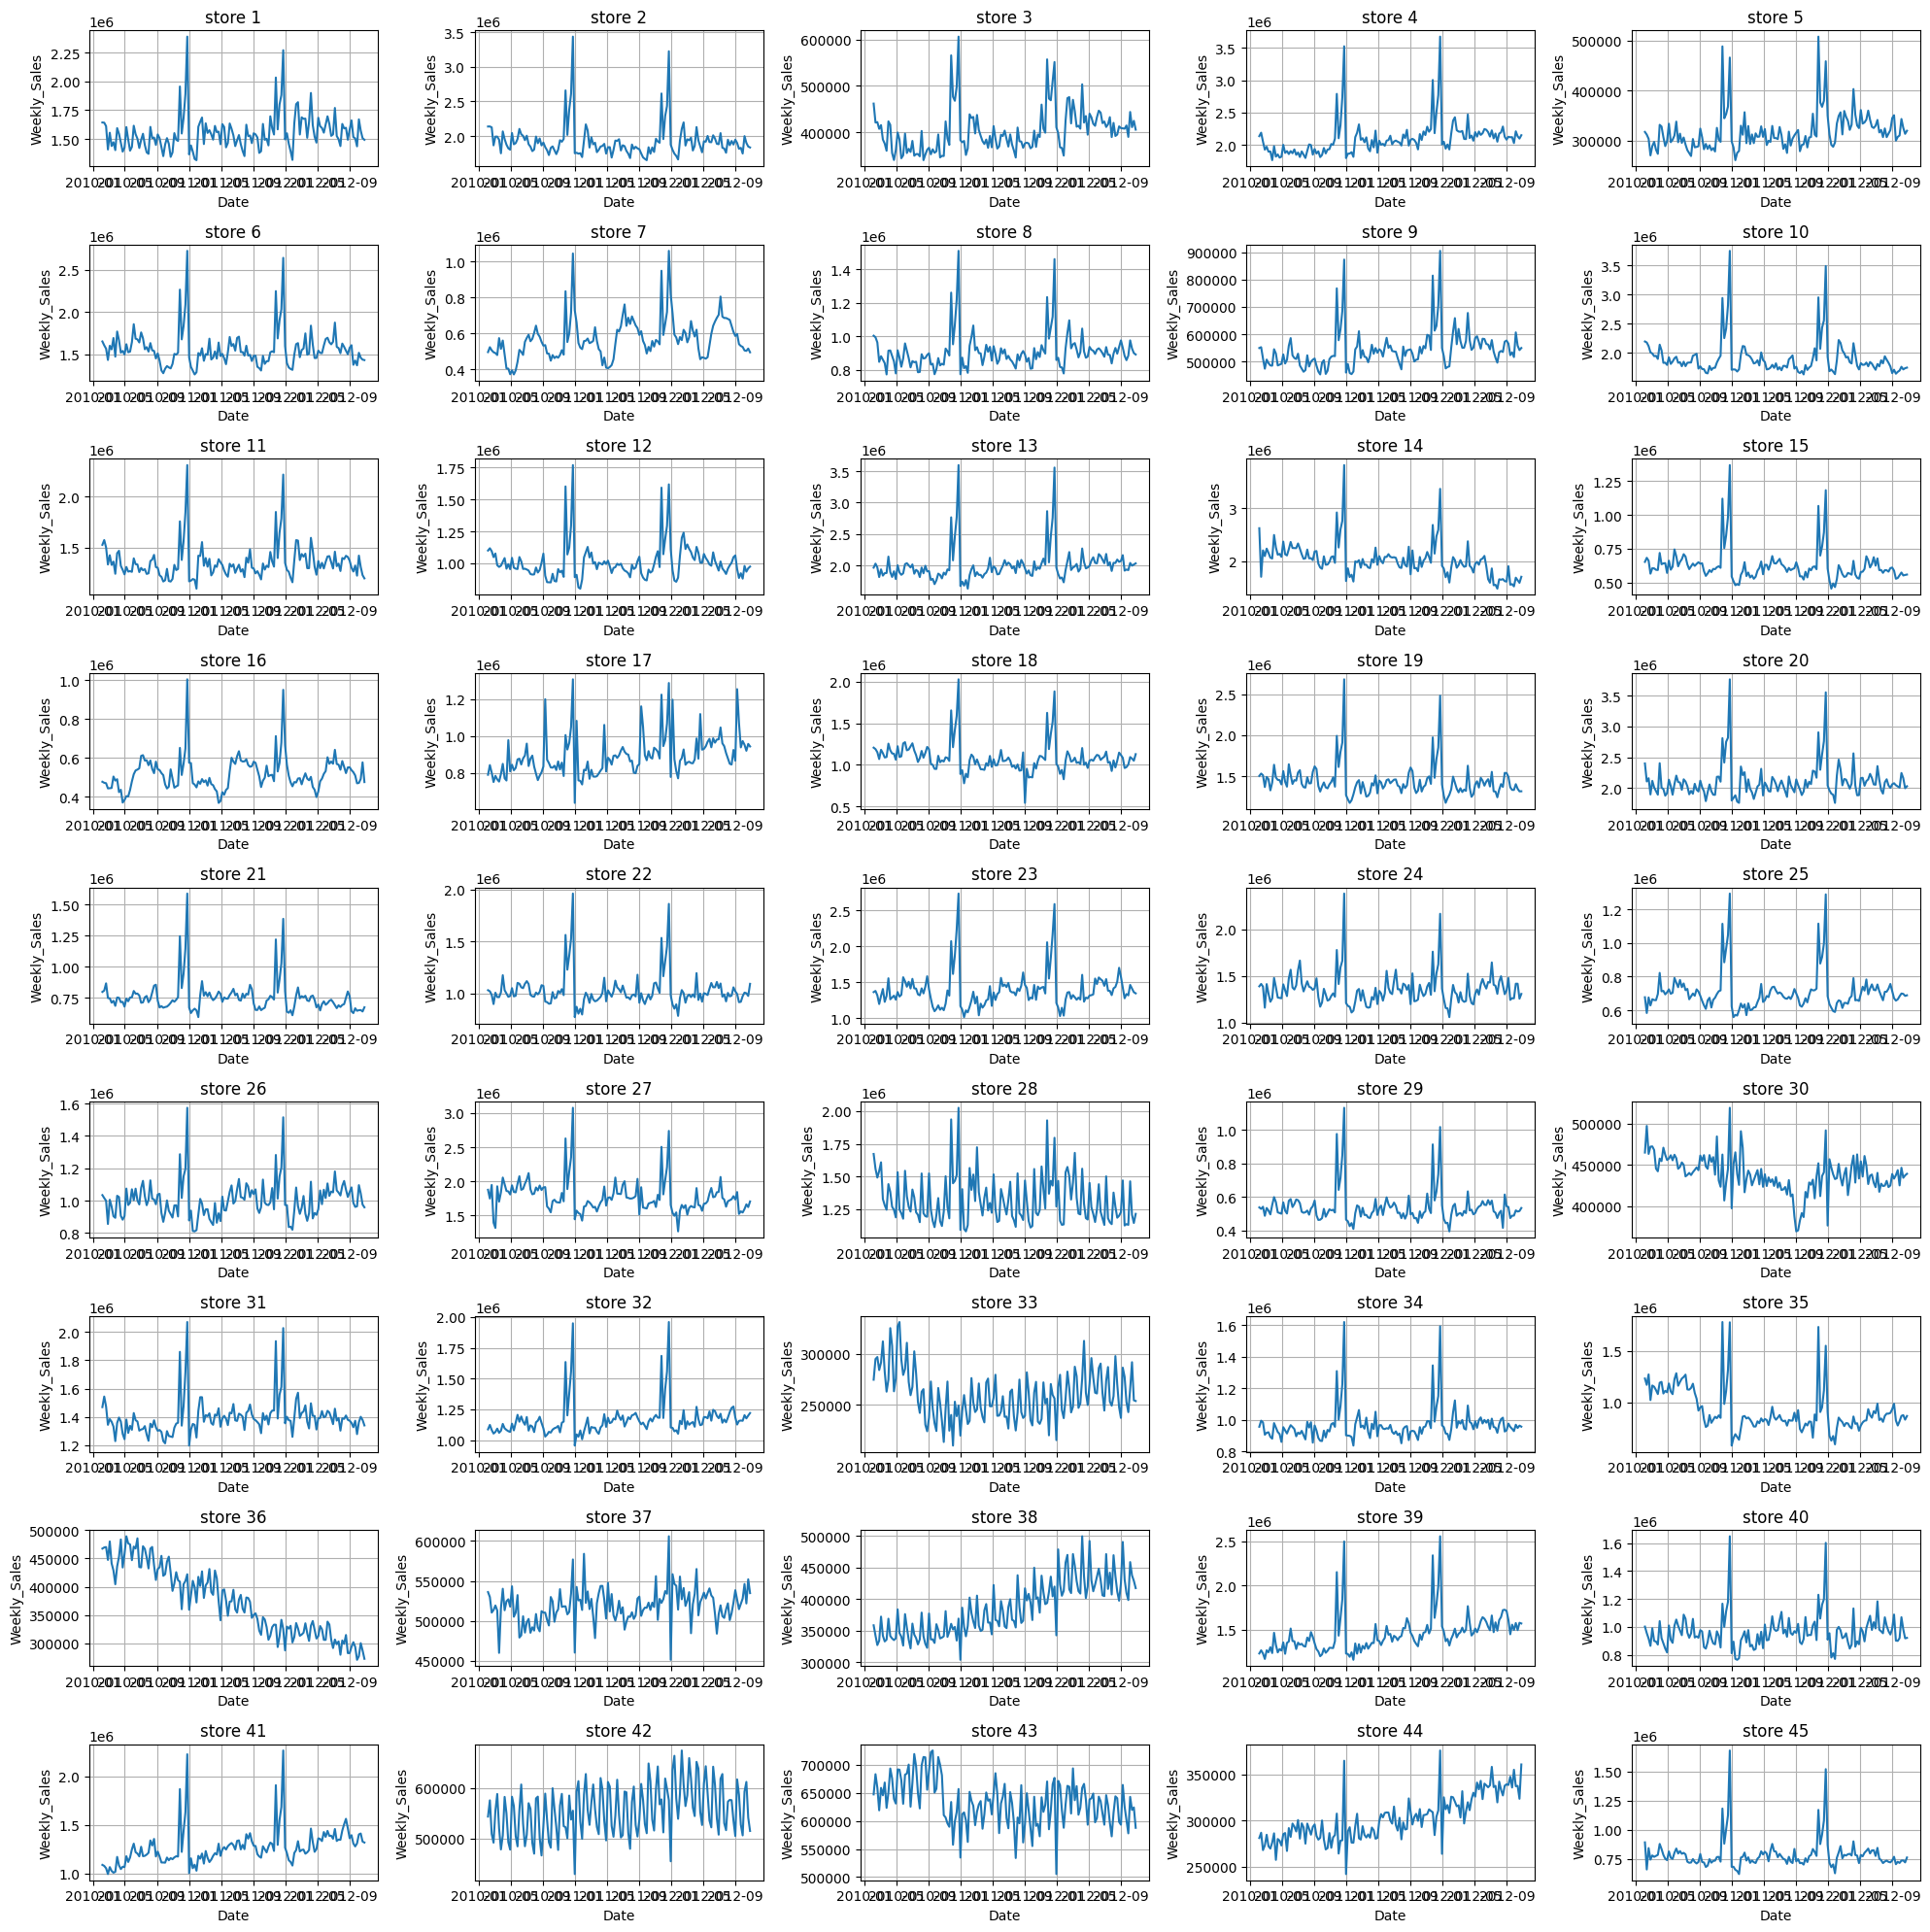

In [ ]:
# SALES DISTRIBUTION OF DATA OF ALL 45 STORES
def visualise_data(df_list):

# Create a grid of 9x5 subplots (since 9*5=45)
  fig, axes = plt.subplots(9, 5, figsize=(20, 20))  # Adjust figsize as needed

# Flatten the axes array for easy iteration
  axes = axes.flatten()

# Iterate over the stores
  for idx in range(1, 46):
      x = df_list[idx].drop('Weekly_Sales', axis=1)
      y = df_list[idx]['Weekly_Sales']
      store_name = 'store ' + str(idx)

      sns.lineplot(ax=axes[idx-1], x=x.index, y=y)
      axes[idx-1].set_title(store_name)
      axes[idx-1].grid(True)

# Adjust layout to prevent overlapping
  plt.tight_layout()
  plt.show()


# visualise data for stores
visualise_data(df_list)

In [16]:
len(df[df['Store']==45])
# all store having data for 143 weeks let's test for 23 weeks and training for 120 weeks

143

In [17]:
# training the second model
def train_models(df_list, stores=10):

    fig, axes = plt.subplots(stores, 1, figsize=(7, stores * 4))  # Adjust number of subplots and figsize as needed
    axes = axes.flatten()  # Flatten the axes array to make it easier to index

    model_list = [0]  # Initialize an empty list to store the models
    for storeIdx in range(stores):  # Iterate over each store in the list

        # Access data for the ith store using storeIdx + 1 to match store numbers 1 to 45
        endog = df_list[storeIdx + 1]['Weekly_Sales']
        exog = df_list[storeIdx + 1][['Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']]

        # Split the data into training and testing sets
        train_size = 120
        train_endog = endog.iloc[:train_size]
        train_exog = exog.iloc[:train_size]
        test_endog = endog.iloc[train_size:]
        test_exog = exog.iloc[train_size:]

        # Fit the SARIMAX model
        model = SARIMAX(train_endog, exog=train_exog, order=(1, 1, 1), seasonal_order=(1, 1, 1, 52)).fit()

        model_list.append(model)  # Append the trained model to the list

        # Predict on the training data (in-sample)
        train_predictions = model.predict(start=train_endog.index[0], end=train_endog.index[-1], exog=train_exog)

        # Predict on the test data (out-of-sample)
        test_predictions = model.predict(start=test_endog.index[0], end=test_endog.index[-1], exog=test_exog)

        # Plot the actual sales data
        sns.lineplot(ax=axes[storeIdx], x=df_list[storeIdx + 1].index, y=df_list[storeIdx + 1]['Weekly_Sales'], label='Actual Sales', color='blue')

        # Plot the predictions on the training data
        sns.lineplot(ax=axes[storeIdx], x=train_endog.index, y=train_predictions, label='Training Predictions', color='green')

        # Plot the predictions on the test data
        sns.lineplot(ax=axes[storeIdx], x=test_endog.index, y=test_predictions, label='Test Predictions', color='red')

        # Add labels, legend, and title
        axes[storeIdx].set_xlabel('Date')
        axes[storeIdx].set_ylabel('Weekly Sales')
        axes[storeIdx].set_title(f'Actual vs Predicted Sales for Store {storeIdx + 1}')
        axes[storeIdx].grid(True)
        axes[storeIdx].legend()

    plt.tight_layout()
    plt.show()

    return model_list  # Return the list of trained models


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:4

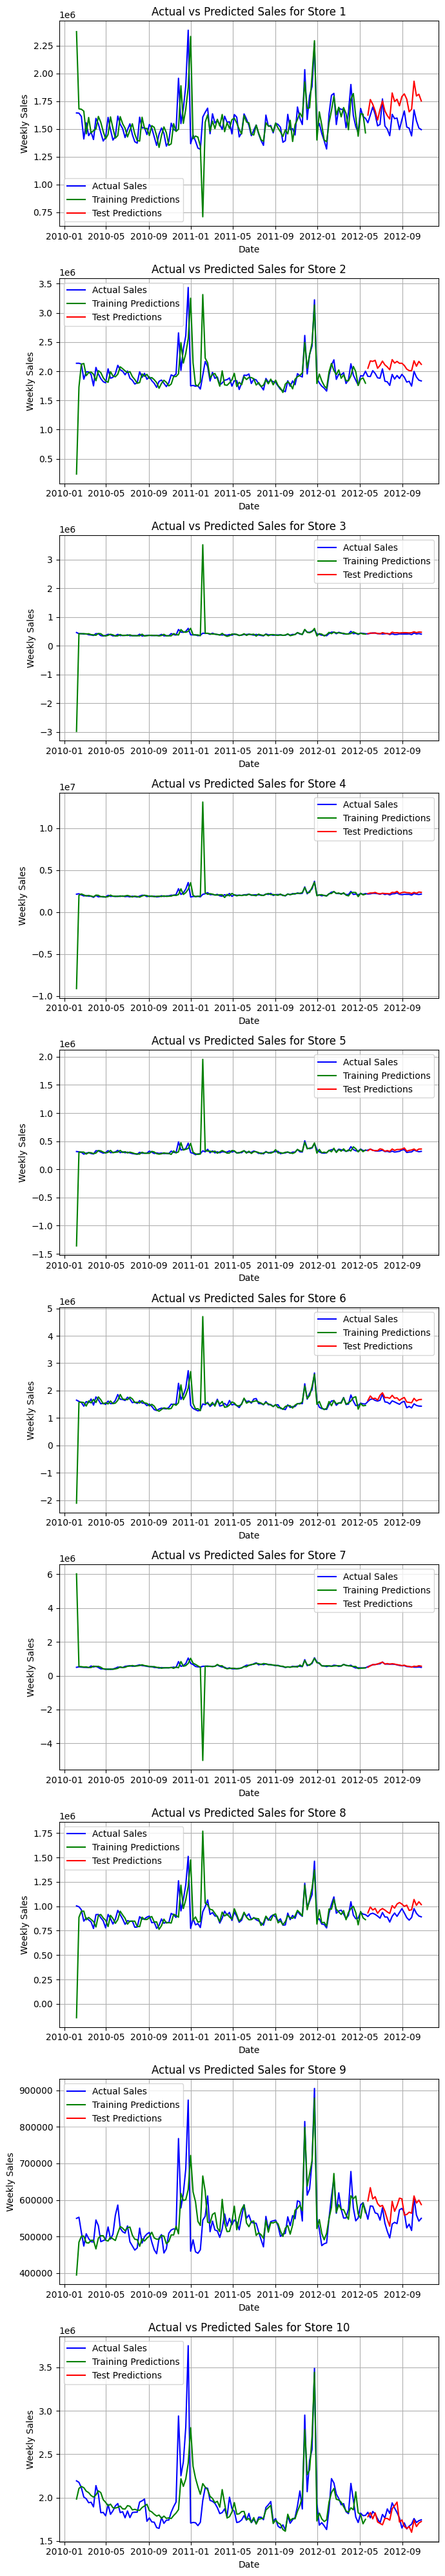

In [18]:
# This model_list contains models for forecasting weekly sales
# ex :- if want to access model for store i then model_list[i] will give the model, 1-based indexing
model_list = train_models(df_list)

In [24]:
for i in range(4, 11):
  filename = 'model_'+str(i)+'.pkl'
  with open(filename, 'wb') as f:
      pkl.dump(model_list[i], f)

In [ ]:
model_1 = None
with open('/content/model_1.pkl', 'rb') as f:
    model_1 = pkl.load(f)


In [19]:
df.columns

Index(['Store', 'Weekly_Sales', 'Holiday_Flag', 'Temperature', 'Fuel_Price',
       'CPI', 'Unemployment'],
      dtype='object')

In [21]:
# Import libraries
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

def train_models_with_arima(df_list, stores=5):

  fig, axes = plt.subplots(stores, 1, figsize=(7, stores * 4))  # Adjust number of subplots and figsize as needed
  axes = axes.flatten()  # Flatten the axes array to make it easier to index

  model_list = []  # Initialize an empty list to store the models

  for storeIdx in range(stores):  # Iterate over each store in the list

    # Access data for the ith store using storeIdx + 1 to match store numbers 1 to 45
    data = df_list[storeIdx + 1]['Weekly_Sales']

    # Split the data into training and testing sets
    train_size = 120
    train_data = data.iloc[:train_size]
    test_data = data.iloc[train_size:]

    # Option 1: ARIMA Model (without exogenous variables)
    model = ARIMA(train_data, order=(1, 1, 1)).fit()
    model_list.append(model)  # Append the trained model to the list

    # Option 2: Time Series Decomposition (alternative approach)
    # decomposition = seasonal_decompose(train_data, model='additive', period=52)  # Adjust period for seasonality
    # model_list.append(decomposition)  # Append the decomposition object (optional)

    # Predict on the training data (in-sample)
    train_predictions = model.predict(start=train_data.index[0], end=train_data.index[-1])

    # Predict on the test data (out-of-sample)
    test_predictions = model.predict(start=test_data.index[0], end=test_data.index[-1])

    # Plot the actual sales data
    sns.lineplot(ax=axes[storeIdx], x=df_list[storeIdx + 1].index, y=df_list[storeIdx + 1]['Weekly_Sales'], label='Actual Sales', color='blue')

    # Plot the predictions on the training data
    sns.lineplot(ax=axes[storeIdx], x=train_data.index, y=train_predictions, label='Training Predictions', color='green')

    # Plot the predictions on the test data
    sns.lineplot(ax=axes[storeIdx], x=test_data.index, y=test_predictions, label='Test Predictions', color='red')

    # Add labels, legend, and title
    axes[storeIdx].set_xlabel('Date')
    axes[storeIdx].set_ylabel('Weekly Sales')
    axes[storeIdx].set_title(f'Actual vs Predicted Sales for Store {storeIdx + 1}')
    axes[storeIdx].grid(True)
    axes[storeIdx].legend()

  plt.tight_layout()
  plt.show()

  return model_list  # Return the list of trained models


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  

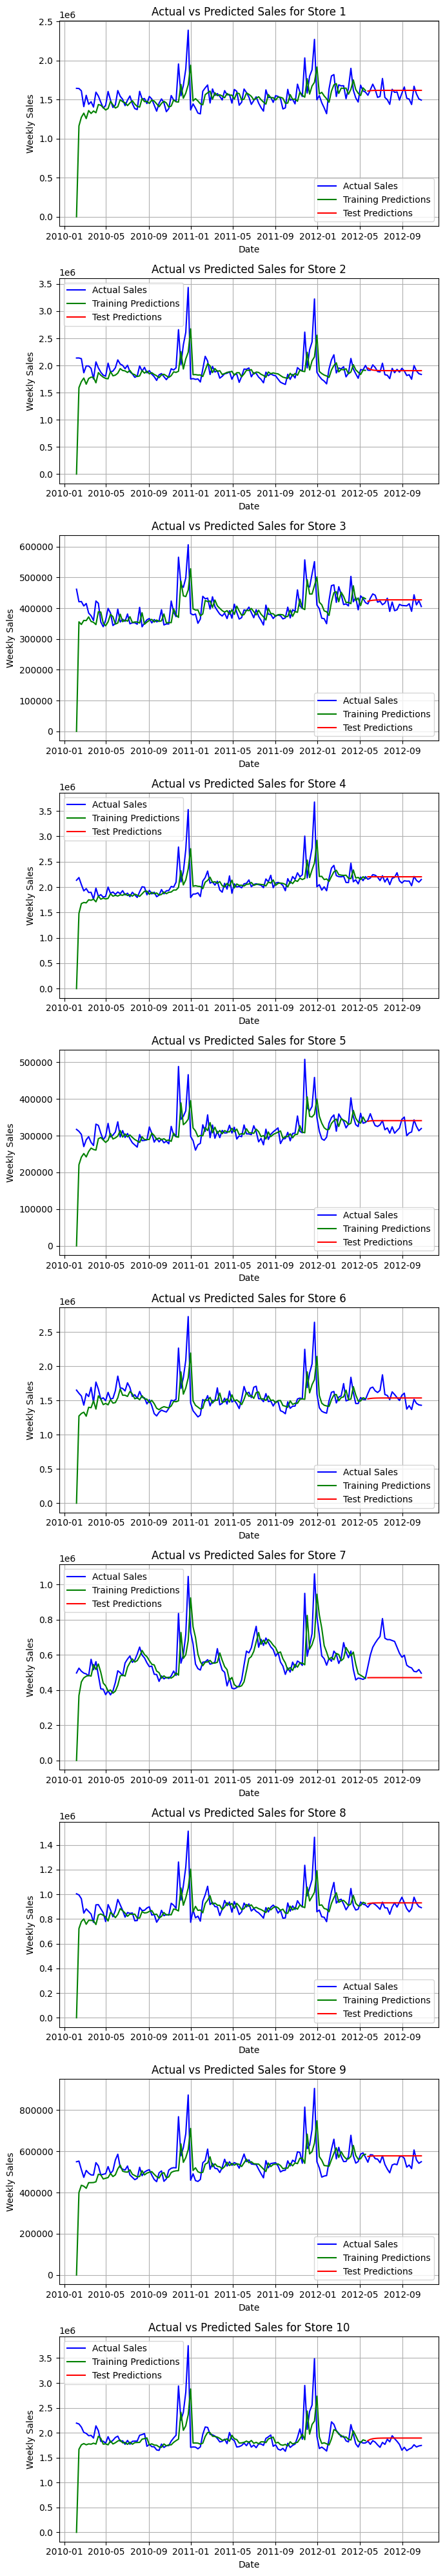

In [22]:
model_list2 = train_models_with_arima(df_list, stores = 10)

In [25]:
for i in range(1, 11):
  filename = 'model_'+str(i)+'arima.pkl'
  with open(filename, 'wb') as f:
      pkl.dump(model_list[i], f)

In [23]:
model_list2[1].forecast(steps=3)

,predicted_mean
2012-05-25,1.951540e+06
2012-06-01,1.927363e+06
2012-06-08,1.915531e+06


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

def train_models_wo_exog2(df_list, stores=10):

  fig, axes = plt.subplots(stores, 1, figsize=(7, stores * 4))
  axes = axes.flatten()

  model_list = []

  for storeIdx in range(stores):

    endog = df_list[storeIdx + 1]['Weekly_Sales']

    train_size = 120
    train_endog = endog.iloc[:train_size]
    test_endog = endog.iloc[train_size:]

    # ARIMA model without exogenous variables
    model = ARIMA(train_endog, order=(1, 1, 1)).fit()  # Adjust order as needed
    model_list.append(model)

    # Predictions
    train_predictions = model.predict(start=train_endog.index[0], end=train_endog.index[-1])
    test_predictions = model.predict(start=test_endog.index[0], end=test_endog.index[-1])

    # Forecasting (example for one month)
    forecast_steps = 4
    future_forecast = model.forecast(steps=forecast_steps)

    # Plotting
    sns.lineplot(ax=axes[storeIdx], x=endog.index, y=endog, label='Actual Sales', color='blue')
    sns.lineplot(ax=axes[storeIdx], x=train_endog.index, y=train_predictions, label='Training Predictions', color='green')
    sns.lineplot(ax=axes[storeIdx], x=test_endog.index, y=test_predictions, label='Test Predictions', color='red')
    sns.lineplot(ax=axes[storeIdx], x=future_forecast.index, y=future_forecast, label='Forecast', color='purple')

    axes[storeIdx].set_xlabel('Date')
    axes[storeIdx].set_ylabel('Weekly Sales')
    axes[storeIdx].set_title(f'Store {storeIdx + 1}')
    axes[storeIdx].grid(True)
    axes[storeIdx].legend()

  plt.tight_layout()
  plt.show()

  return model_list


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  

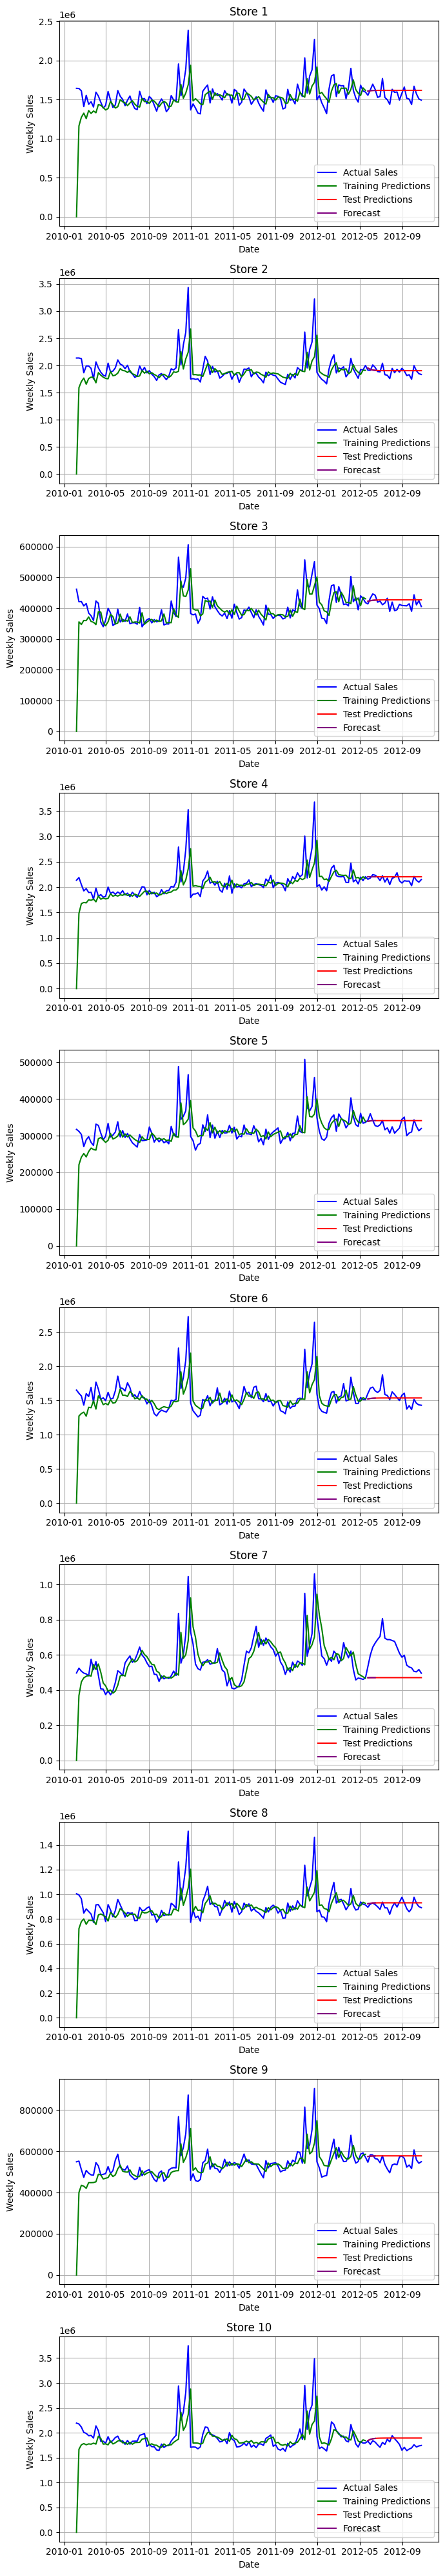

In [ ]:
model_list3 = train_models_wo_exog2(df_list, stores=10)